In [1]:
%pip install gymnasium

Note: you may need to restart the kernel to use updated packages.


In [3]:
%pip install torch

  Using cached filelock-3.16.1-py3-none-any.whl.metadata (2.9 kB)
  Using cached networkx-3.4.2-py3-none-any.whl.metadata (6.3 kB)
  Using cached fsspec-2024.10.0-py3-none-any.whl.metadata (11 kB)
  Using cached sympy-1.13.1-py3-none-any.whl.metadata (12 kB)
  Using cached mpmath-1.3.0-py3-none-any.whl.metadata (8.6 kB)
   ---------------------------------------- 0.0/203.1 MB ? eta -:--:--
   ---------------------------------------- 0.3/203.1 MB ? eta -:--:--
   ---------------------------------------- 0.5/203.1 MB 1.3 MB/s eta 0:02:37
   ---------------------------------------- 0.8/203.1 MB 1.6 MB/s eta 0:02:07
   ---------------------------------------- 1.3/203.1 MB 1.7 MB/s eta 0:02:01
   ---------------------------------------- 1.3/203.1 MB 1.7 MB/s eta 0:02:01
   ---------------------------------------- 1.8/203.1 MB 1.5 MB/s eta 0:02:12
   ---------------------------------------- 2.4/203.1 MB 1.6 MB/s eta 0:02:05
    --------------------------------------- 2.6/203.1 MB 1.6 MB/s et

In [3]:
import gymnasium as gym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import deque
import random
from tqdm import tqdm

import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim


In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
# Define model
class QNetwork(nn.Module):

    def __init__(self, state_shape, h1_nodes, action_space_size, seed):
        """ state_shape (int): Dimension of each state
            h1_nodes (int): Number of nodes in first hidden layer
            action_space_size (int): Dimension of each action
            seed (int): Random seed
        """
        super(QNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
         ## add three fully connected layers using nn.Linear()
         #-----------------add code here-----------------------
        self.fc1 = nn.Linear(state_shape, h1_nodes)
        self.fc2 = nn.Linear(h1_nodes, h1_nodes)  # Adding a second hidden layer
        self.fc3 = nn.Linear(h1_nodes, action_space_size)


    def forward(self, state):
      # define the forward propagation  by adding the relu() activation function between layers
      #-----------------add code here----------------------- 
      x = F.relu(self.fc1(state))
      x = F.relu(self.fc2(x))  # Applying ReLU to the second hidden layer
      x = self.fc3(x)  # Output layer (no activation for Q-values)
      return x

In [6]:
# Define memory for Experience Replay
class ReplayMemory():
    def __init__(self, maxlen, batch_size, memRandomFlag=True):
        self.memory = deque([], maxlen=maxlen)
        self.batch_size = batch_size
        self.memRandomFlag = memRandomFlag # Flag to decide whether to use random sampling or not. Default is True.  #-----------------add code here-----------------------

    def append(self, experience):
        self.memory.append(experience)

    def sample(self):
        #Randomly sample a batch of experiences from memory 
        #-----------------add code here-----------------------
        batch_size = min(self.batch_size, len(self.memory)) # Handle case where memory is smaller than batch size
        if self.memRandomFlag:
            experiences = random.sample(self.memory, k=batch_size)
        else:
            experiences = list(self.memory)[-batch_size:]  # Return last k experiences 
        return experiences #Return the sampled experiences

    def __len__(self):
        return len(self.memory)

In [7]:
#Define the Deep QLearning Agent
class DQAgent():
        """Interacts with and learns from the environment."""

        def __init__(self, state_shape, action_space_size, seed, memRandomFlag=True, h1_nodes=64, learning_rate=5e-4, replay_memory_size=int(1e5),batch_size=64, UPDATE_EVERY=20, LEARN_EVERY=4,GAMMA=0.99):
           """Initialize an Agent object. """

           self.state_shape = state_shape
           self.action_space_size = action_space_size
           self.seed = random.seed(seed)
           self.GAMMA = GAMMA
           self.UPDATE_EVERY = UPDATE_EVERY
           self.LERN_EVERY = LEARN_EVERY
           self.h1_nodes = h1_nodes
           self.learning_rate = learning_rate
           self.batch_size = batch_size
           self.replay_memory_size = replay_memory_size
           self.memRandomFlag = memRandomFlag


           # Q-Network
           # create the local and the target networks
           self.local_dqn = QNetwork(state_shape, h1_nodes, action_space_size, seed).to(device) #--add code here---
           self.target_dqn = QNetwork(state_shape, h1_nodes, action_space_size, seed).to(device) #--add code here---

           self.optimizer = optim.Adam(self.local_dqn.parameters(), lr=self.learning_rate)

           # Replay memory
           self.memory = ReplayMemory( self.replay_memory_size,self.batch_size,self.memRandomFlag)

           # Initialize time step (for learn every LEARN_EVERY steps)
           self.l_step = 0

           # Initialize time step (for updating every UPDATE_EVERY steps)
           self.t_step = 0
            
        def state_to_dqn_input(self, state)->torch.Tensor:
           return torch.from_numpy(state).float().unsqueeze(0).to(device)

        #Returns actions for given state
        #Epsilon-greedy action selection
        def act(self, state, eps=0.):
          state = torch.from_numpy(state).float().unsqueeze(0).to(device) # Convert state to tensor HERE
          if random.random() > eps:
            #--add code here---
            self.local_dqn.eval()  # Set to evaluation mode
            with torch.no_grad():
                action_values = self.local_dqn(state)
            self.local_dqn.train()  # Back to training mode
            return np.argmax(action_values.cpu().data.numpy())
          else:
            #--add code here---
            return random.choice(np.arange(self.action_space_size))

        def step(self, state, action, reward, next_state, done):
           # Save experience in replay memory
           #----------add code here---
           self.memory.append((state, action, reward, next_state, done))

           # If enough samples are available in memory, get random subset and learn
           self.l_step = (self.l_step + 1) % self.LERN_EVERY
           if self.l_step == 0 and len(self.memory) > self.batch_size:
                experiences = self.memory.sample() #--add code here---
                #--add code here---
                self.learn(experiences)  # Call learn method

           # Copy local network to target network every UPDATE_EVERY time steps
           self.t_step = (self.t_step + 1) % self.UPDATE_EVERY
           if self.t_step == 0:
              #--add code here---
              self.target_dqn.load_state_dict(self.local_dqn.state_dict())

        def learn(self, experiences):
          q_target_list = []
          q_expected_list = []
          # Obtain random minibatch of tuples from ReplayMemory
          for  state, action, reward, next_state, done in experiences:
          
             # Convert state, next_state, action abd reward to tensors 
             state = self.state_to_dqn_input(state) #--add code here---
             next_state = self.state_to_dqn_input(next_state) #--add code here---
             #action= torch.from_numpy(np.array([action])).long().unsqueeze(0).to(device)
             action = torch.tensor([[action]]).long().to(device)  # Double brackets for correct 2D shape
             #reward = torch.from_numpy(np.array([reward])).float().to(device)
             reward = torch.tensor([reward], dtype=torch.float).to(device).unsqueeze(0) # unsqueeze for consistent dimensions
             ## Compute and minimize the loss

             ### Extract next maximum estimated value from target network
             if(done):
               q_target =  reward#--add code here---
             else:
               q_target=  reward + self.GAMMA * self.target_dqn(next_state).detach().max(1)[0].unsqueeze(0) #--add code here---

             ### Calculate expected value from local network
             q_local = self.local_dqn(state).gather(1, action) #--add code here---

             q_target_list.append(q_target)
             q_expected_list.append(q_local)

          ### Loss calculation (we used Mean squared error)
          #loss = F.mse_loss(torch.cat(q_expected_list), torch.cat(q_target_list))*
          # Concatenate along dimension 0 to handle potential 1D tensors
          loss = F.mse_loss(torch.cat(q_expected_list, dim=0), torch.cat(q_target_list, dim=0))
          self.optimizer.zero_grad()
          loss.backward()
          self.optimizer.step()


        

In [8]:
def dqn_train(agent, env, n_episodes=300, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):

    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon

    for i_episode in  tqdm(range(1, n_episodes+1)):
        state = env.reset()[0]

        score = 0
        for t in range(max_t):
            # select an action
            action = agent.act(state, eps) #--add code here---

            #apply the selected action
            next_state, reward, done, _,_= env.step(action)
            
            # store the current experience
            #--add code here---
            agent.step(state, action, reward, next_state, done) 

            state = next_state
            score += reward
            if done:
                break
                
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon

        if i_episode % 50 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))

    torch.save(agent.local_dqn.state_dict(), 'checkpoint.pth')
    return scores

In [9]:
env = gym.make('CartPole-v1')
print(env.reset())

print('State shape: ', env.observation_space.shape[0])
print('Number of actions: ', env.action_space.n)

(array([-0.02616323,  0.04332437, -0.04459446,  0.01779469], dtype=float32), {})
State shape:  4
Number of actions:  2


In [31]:
agent = DQAgent(state_shape=env.observation_space.shape[0], action_space_size=env.action_space.n, seed=0)
scores = dqn_train(agent, env)

 17%|█▋        | 52/300 [00:06<00:27,  8.93it/s]

Episode 50	Average Score: 17.44


 34%|███▎      | 101/300 [00:12<00:29,  6.73it/s]

Episode 100	Average Score: 16.97


 50%|█████     | 150/300 [00:25<00:59,  2.52it/s]

Episode 150	Average Score: 22.33


 67%|██████▋   | 200/300 [00:59<01:14,  1.34it/s]

Episode 200	Average Score: 51.50


 83%|████████▎ | 250/300 [02:01<01:03,  1.28s/it]

Episode 250	Average Score: 104.70


100%|██████████| 300/300 [03:24<00:00,  1.46it/s]

Episode 300	Average Score: 154.06


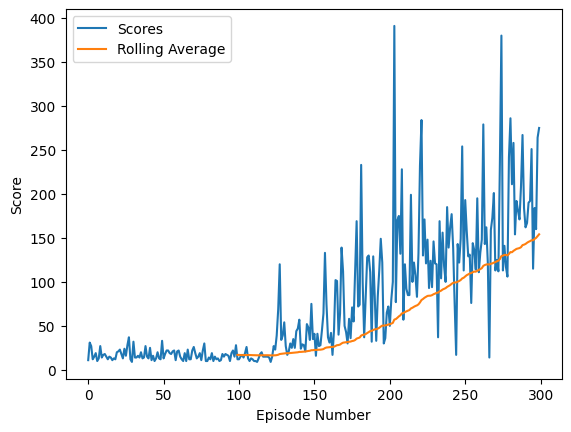

In [32]:
scores = pd.Series(scores, name="scores")
scores.describe()
fig, ax = plt.subplots(1, 1)
_ = scores.plot(ax=ax, label="Scores")
_ = (scores.rolling(window=100)
           .mean()
           .rename("Rolling Average")
           .plot(ax=ax))
ax.legend()
_ = ax.set_xlabel("Episode Number")
_ = ax.set_ylabel("Score")

In [10]:
agent2 = DQAgent(state_shape=env.observation_space.shape[0], action_space_size=env.action_space.n, seed=0,memRandomFlag=False)
scores2 = dqn_train(agent2, env)

 17%|█▋        | 50/300 [00:06<00:28,  8.86it/s]

Episode 50	Average Score: 20.36


 34%|███▎      | 101/300 [00:14<00:27,  7.14it/s]

Episode 100	Average Score: 20.35


 50%|█████     | 150/300 [00:28<01:13,  2.04it/s]

Episode 150	Average Score: 27.43


 67%|██████▋   | 200/300 [00:48<00:36,  2.72it/s]

Episode 200	Average Score: 40.92


 83%|████████▎ | 250/300 [01:27<01:15,  1.51s/it]

Episode 250	Average Score: 60.29


100%|██████████| 300/300 [02:45<00:00,  1.81it/s]

Episode 300	Average Score: 113.20


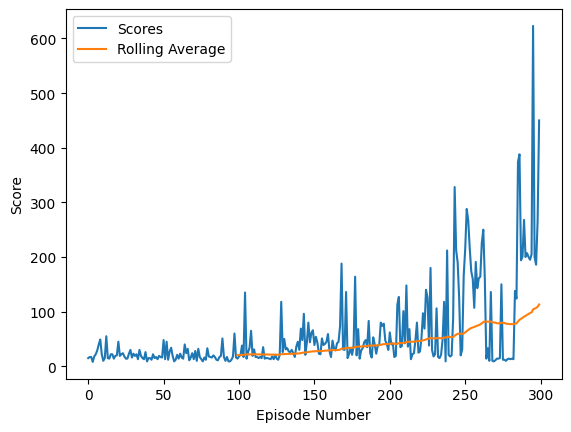

In [11]:
scores2 = pd.Series(scores2, name="scores")
scores2.describe()
fig, ax = plt.subplots(1, 1)
_ = scores2.plot(ax=ax, label="Scores")
_ = (scores2.rolling(window=100)
           .mean()
           .rename("Rolling Average")
           .plot(ax=ax)) 
ax.legend()
_ = ax.set_xlabel("Episode Number")
_ = ax.set_ylabel("Score")